# PyTorch Geometric 

PyTorch Geometric (PyG) is an extension library for PyTorch. 


In [117]:
import torch
print("PyTorch has version {}".format(torch.__version__))
print("Cuda version {}".format(torch.version.cuda))

PyTorch has version 1.11.0
Cuda version 11.3


## Installing dependencies

The installation of PyG on Colab 
PyG's installation page : https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html 



In [118]:
# Install torch geometric for PyTorch 1.11.* and CUDA 11.3
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
#!pip install torch-geometric

## Visualization

In [119]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

## Dataset

PyTorch Geometric provides the dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage :

In [120]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1
Number of features: 34
Number of classes: 4


* Inspect some of the properties.

In [121]:
data = dataset[0]  # Get the first graph object.

print(data)
# edge index = graph connectivity , x = nodes features , y = nodes labels  
print('==============================================================')

# Gather some statistics about the graph.
print(f'Is undirected: {data.is_undirected()}')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
# Nodes with ground truth labels
print(f'Number of training nodes: {data.train_mask.sum()}')

print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Is undirected: True
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Data

## Visualizing the graph

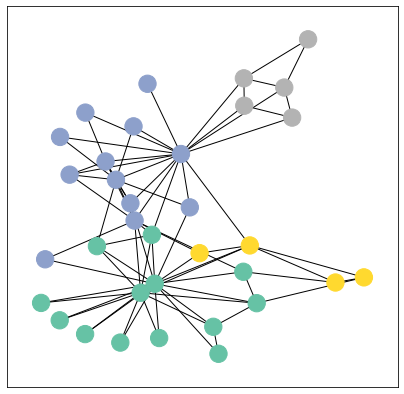

In [122]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

## Implementing Graph Neural Networks 

Use one of the most simple GNN operators, the GCN layer, PyG implements this layer via GCNConv

In [123]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        # Three graph convolution layers
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        # Apply a single linear transformation it acts as a classifier nodes to 1 out of the 4 classes
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


## Embedding the Karate Club Network


Embedding shape: [34, 2]


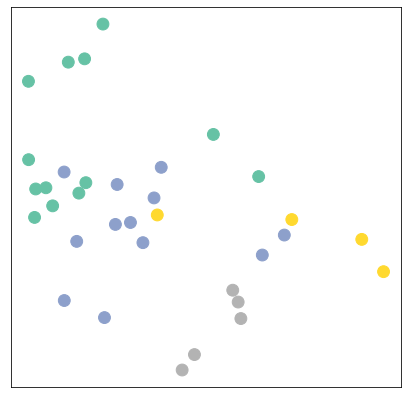

In [124]:
model = GCN()
# Pass initial node features and the graph connectivity information
_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')
# Visualize result
visualize(h, color=data.y)

## Training

<IPython.core.display.Javascript object>

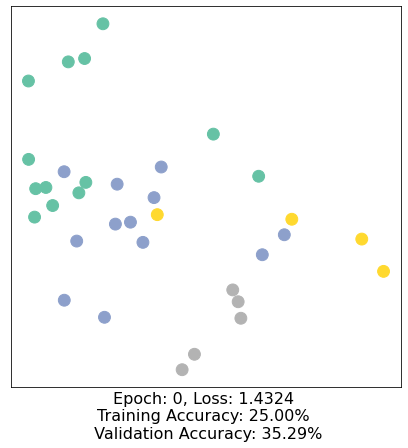

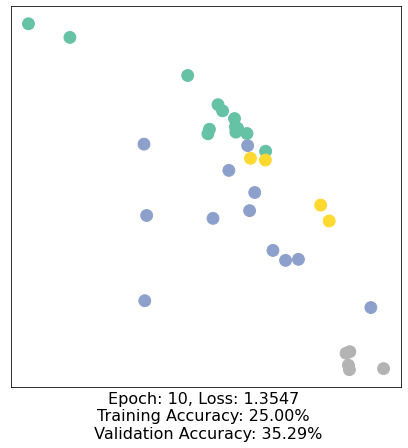

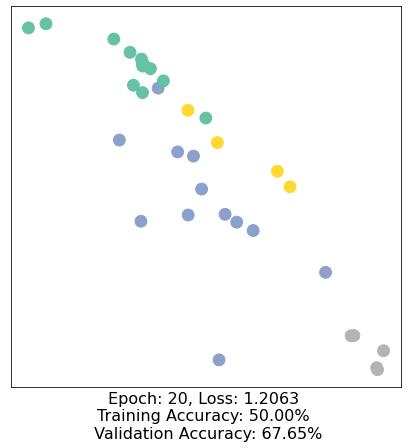

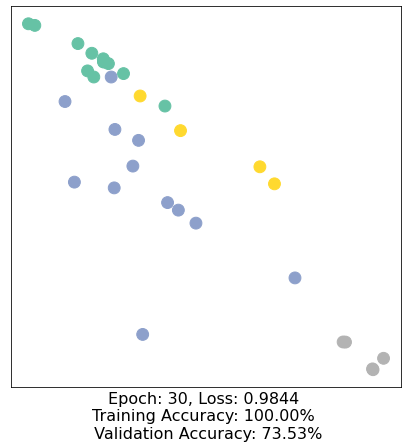

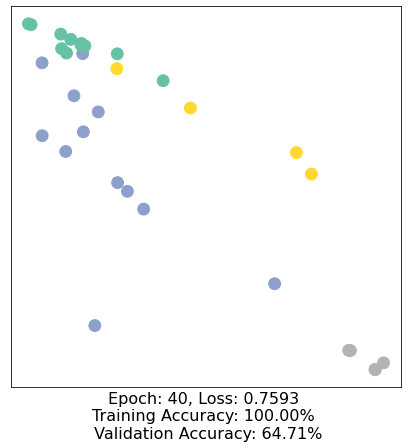

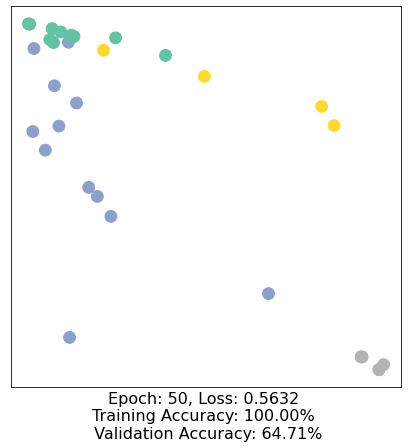

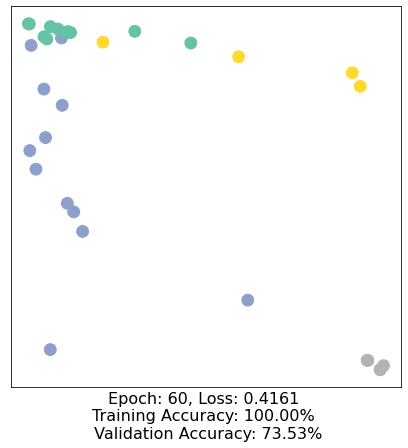

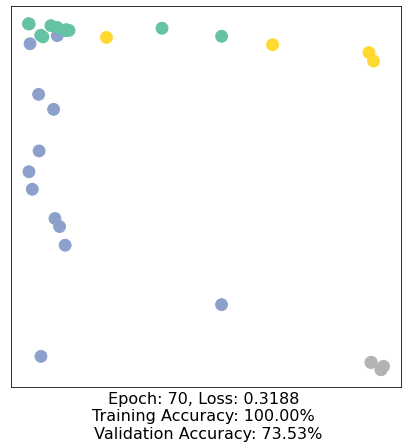

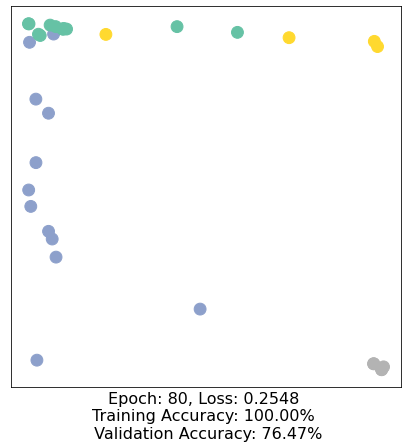

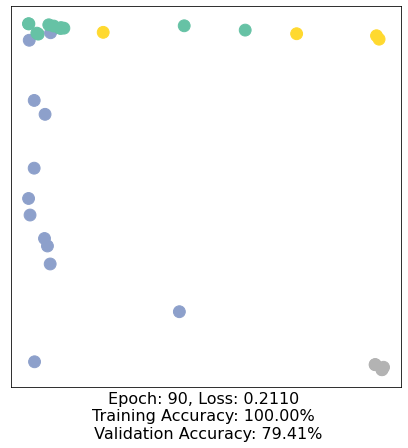

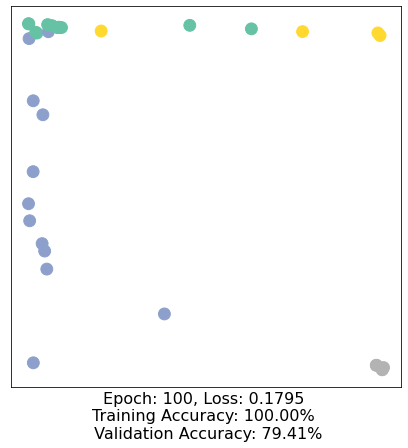

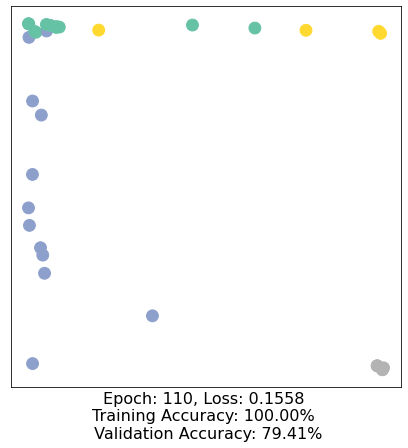

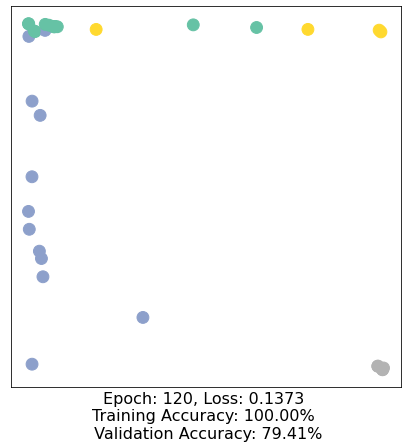

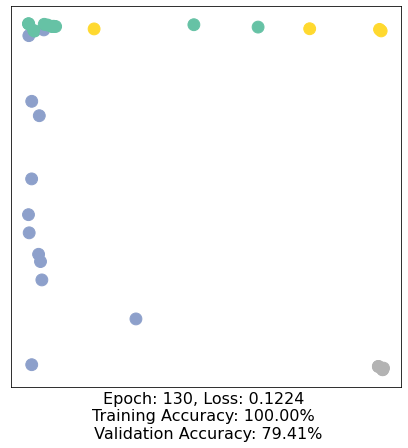

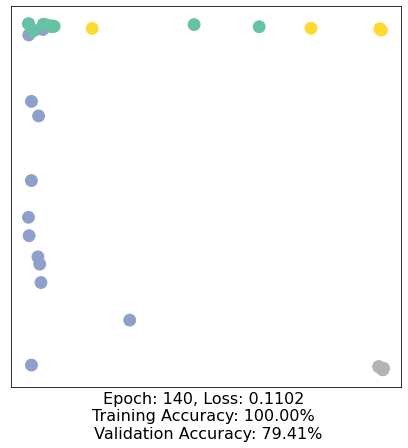

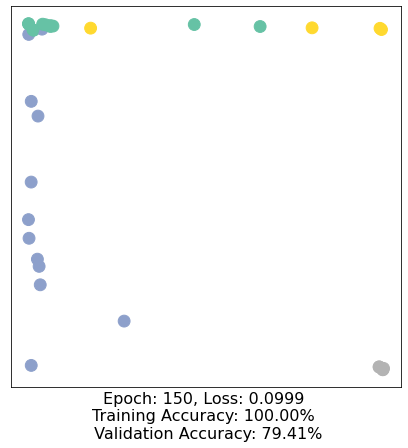

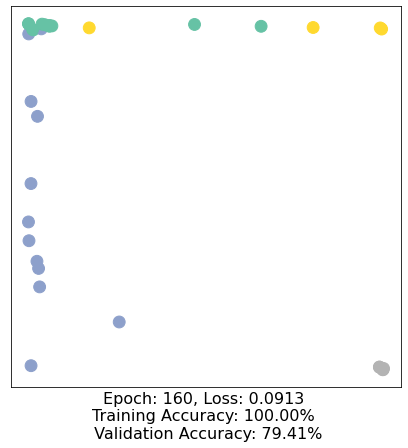

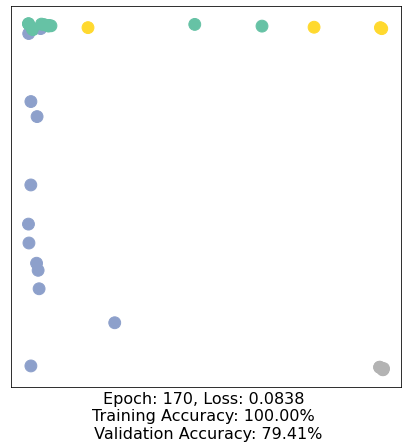

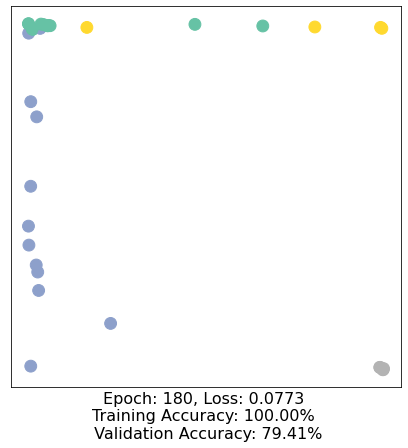

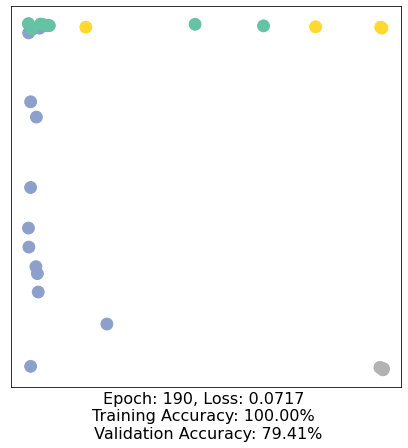

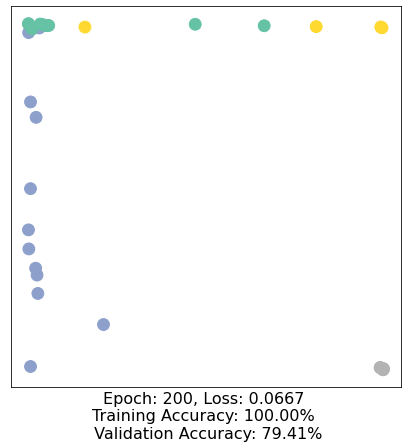

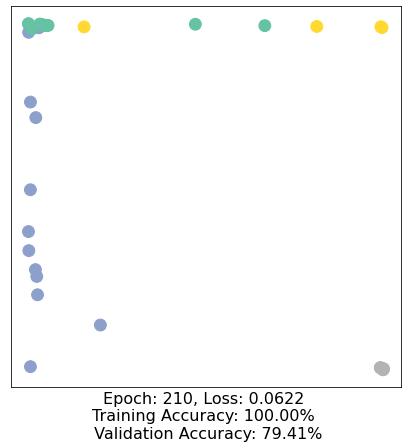

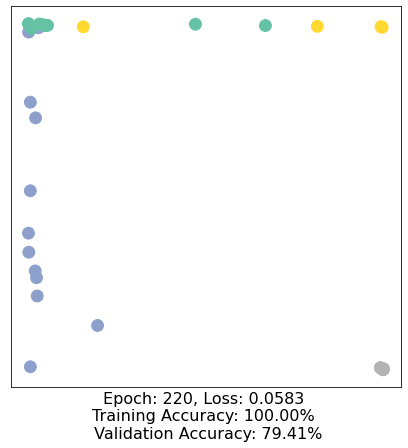

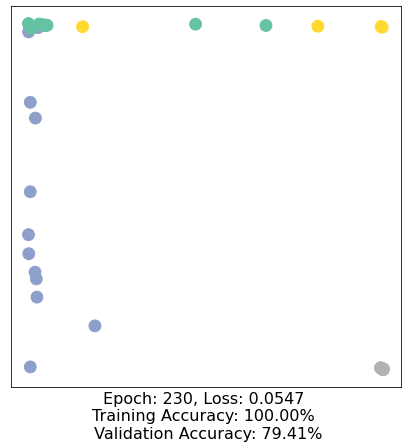

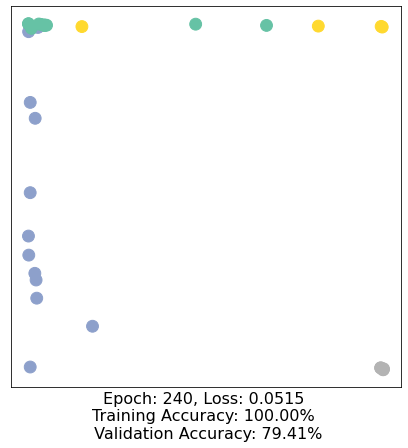

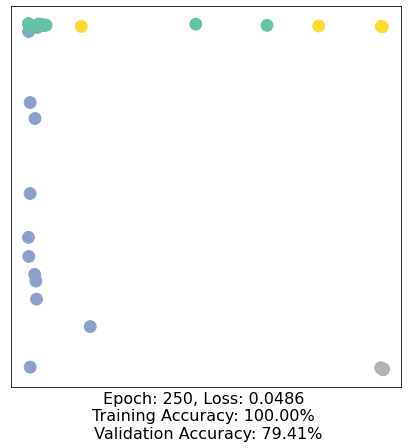

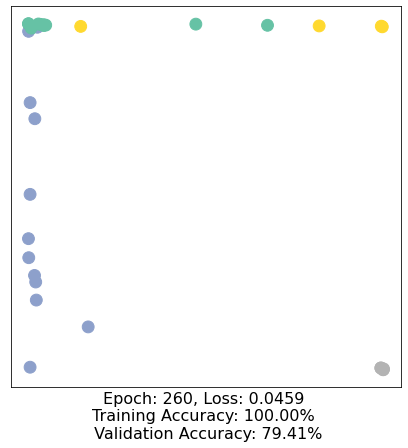

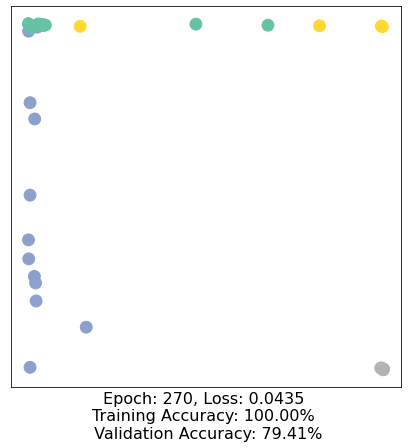

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)

## Ref :



PyG : https://pytorch-geometric.readthedocs.io/en/latest/